# Network Anomaly Detection - Supervised Machine Learning Modeling

**Problem Statement**
>In the realm of cybersecurity, network anomaly detection is a critical task that involves identifying unusual patterns or behaviors that deviate from the norm within network traffic.
These anomalies could signify a range of security threats, from compromised devices and malware infections to large-scale cyber-attacks like DDoS (Distributed Denial of Service). The challenge lies in accurately detecting these anomalies in real-time, amidst the vast and continuous streams of network data, which are often noisy and heterogeneous. 
The traditional methods of network anomaly detection often rely on predefined rules or signatures based on known attack patterns. However, these methods fall short in detecting new or evolving threats that do not match the existing signatures. Furthermore, as network environments grow in complexity, maintaining and updating these rules becomes increasingly 
cumbersome and less effective. 

**Import required Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
#pd.set_option("display.precision", 2)

import warnings
warnings.filterwarnings("ignore")

In [142]:
import os
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#Accuracy score, confusion matrix, classification report, ROC curve, AUC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

In [128]:
from sklearn.metrics import (plot_confusion_matrix, plot_roc_curve)

**High Level Overview and basic info of the Dataset**

In [451]:
df = pd.read_csv("Network_anomaly_data.csv")
df.head(4)

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,attack,lastflag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.0,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.0,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.0,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.0,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21


In [445]:
df.shape

(125973, 43)

In [446]:
df.isnull().sum().sum()

np.int64(0)

**Data Dictionary:**
> **Basic Connection Features**
1. Duration: Length of time duration of the connection.
2. Protocol_type: Protocol used in the connection.
3. Service: Destination network service used.
4. Flag: Status of the connection (Normal or Error).
5. Src_bytes: Number of data bytes transferred from source to destination in a single connection.
6. Dst_bytes: Number of data bytes transferred from destination to source in a single connection.
7. Land: Indicator if source and destination IP addresses and port numbers are equal (1 if equal, 0 otherwise).
8. Wrong_fragment: Total number of wrong fragments in this connection.
9. Urgent: Number of urgent packets in this connection. Urgent packets are packets with the urgent bit activated.
   > **Content-Related Features**
10. Hot: Number of 'hot' indicators in the content, such as entering a system directory, creating programs, and executing programs.
11. Num_failed_logins: Count of failed login attempts.
12. Logged_in: Login status (1 if successfully logged in, 0 otherwise).
13. Num_compromised: Number of 'compromised' conditions.
14. Root_shell: Indicator if root shell is obtained (1 if yes, 0 otherwise).
15. Su_attempted: Indicator if 'su root' command is attempted or used (1 if yes, 0 otherwise).
16. Num_root: Number of 'root' accesses or operations performed as root in the connection.
17. Num_file_creations: Number of file creation operations in the connection.
18. Num_shells: Number of shell prompts.
19. Num_access_files: Number of operations on access control files.
20. Num_outbound_cmds: Number of outbound commands in an ftp session.
21. Is_hot_login: Indicator if the login belongs to the 'hot' list, i.e., root or admin (1 if yes, 0 otherwise).
22. Is_guest_login: Indicator if the login is a 'guest' login (1 if yes, 0 otherwise).
    >>**Time-Related Traffic Features**
23. Count: Number of connections to the same destination host as the current connection in the past two seconds.
24. Srv_count: Number of connections to the same service as the current connection in the past two seconds.
25. Serror_rate: Percentage of connections that have activated the flag s0, s1, s2, or s3, among the connections aggregated in count.
26. Srv_serror_rate: Percentage of connections that have activated the flag s0, s1, s2, or s3, among the connections aggregated in srv_count.
27. Rerror_rate: Percentage of connections that have activated the flag REJ, among the connections aggregated in count.
28. Srv_rerror_rate: Percentage of connections that have activated the flag REJ, among the connections aggregated in srv_count.
29. Same_srv_rate: Percentage of connections that were to the same service, among the connections aggregated in count.
23. Diff_srv_rate: Percentage of connections that were to different services, among the connections aggregated in count.
24. Srv_diff_host_rate: Percentage of connections that were to different destination machines, among the connections aggregated in srv_count.
    >**Host-Based Traffic Features**
32. Dst_host_count: Number of connections having the same destination host IP address.
33. Dst_host_srv_count: Number of connections having the same port number.
34. Dst_host_same_srv_rate: Percentage of connections that were to the same service, among the connections aggregated in dst_host_count.
35. Dst_host_diff_srv_rate: Percentage of connections that were to different services, among the connections aggregated in dst_host_count.
36. Dst_host_same_src_port_rate: Percentage of connections that were to the same source port, among the connections aggregated in dst_host_srv_count.
37. Dst_host_srv_diff_host_rate: Percentage of connections that were to different destination machines, among the connections aggregated in dst_host_srv_count.
38. Dst_host_serror_rate: Percentage of connections that have activated the flag s0, s1, s2, or s3, among the connections aggregated in dst_host_count.
39. Dst_host_srv_serror_rate: Percentage of connections that have activated the flag s0, s1, s2, or s3, among the connections aggregated in dst_host_srv_count.
40. Dst_host_rerror_rate: Percentage of connections that have activated the flag REJ, among the connections aggregated in dst_host_count.
41. Dst_host_srv_rerror_rate: Percentage of connections that have activated the flag REJ, among the connections aggregated in dst_host_srv_count.

## Summary Statistics

In [447]:
df.describe(include = ['int64', 'float64'])

,duration,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.0,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,0.001342,0.001103,0.302192,0.012669,0.000413,0.004096,0.0,0.000008,0.009423,84.107555,27.737888,0.284485,0.282485,0.119958,0.121183,0.660928,0.063053,0.097322,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240,19.504060
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,0.036603,0.045154,24.399618,0.483935,0.022181,0.099370,0.0,0.002817,0.096612,114.508607,72.635840,0.446456,0.447022,0.320436,0.323647,0.439623,0.180314,0.259830,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459,2.291503
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,143.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,21.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,1.000000,2.000000,7468.000000,43.000000,2.000000,9.000000,0.0,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


In [448]:
df.describe(include= 'object')

,protocoltype,service,flag,attack
count,125973,125973,125973,125973
unique,3,70,11,23
top,tcp,http,SF,normal
freq,102689,40338,74945,67343


### **Data Pre-processing**

**The following is the attack categorization:**
###### DoS :	Denial of service is a malicious attack aimed at preventing normal users from using a service by making it inaccessible.
###### Probe:	Probe or surveillance is an attack that her purpose is to obtain important information about the security of networks in order to
######       change with the security settings.
###### R2L:	This class of attacks tries to gain local unauthorized access to a remote machine by sends packets to the network.
###### U2R	: The primary purpose of this attack is to illegally explore or steal data, install viruses, or cause the sufferer to suffer harm by introduction a normal user account.

###### DOS : ['neptune', 'back', 'land', 'pod', 'smurf', 'teardrop', 'udpstorm', 'mailbomb', 'apache2', 'processtable', 'worm']
###### Probe : ['ipsweep', 'nmap', 'portsweep', 'satan', 'mscan', 'saint']
###### R2L :['ftp_write','guess_passwd','imap','multihop','phf','spy','warezclient','warezmaster','sendmail','named','snmpgetattack','snmpguess',
######       'xlock','xsnoop', 'httptunnel']
###### U2R : ['buffer_overflow', 'Loadmodule', 'perl', 'rootkit','ps', 'sqlattack', 'xterm']

**Mapping the Target variable**

In [452]:
attack_mapping = {'back': 'dos',    'buffer_overflow': 'u2r',     'ftp_write': 'r2l',    'guess_passwd': 'r2l',    'imap': 'r2l',
    'ipsweep': 'probe',    'land': 'dos',    'loadmodule': 'u2r',    'multihop': 'r2l',    'neptune': 'dos',    'nmap': 'probe',
    'perl': 'u2r',    'phf': 'r2l',    'pod': 'dos',    'portsweep': 'probe',    'rootkit': 'u2r',    'satan': 'probe',
    'smurf': 'dos',    'spy': 'r2l',    'teardrop': 'dos',    'warezclient': 'r2l',    'warezmaster': 'r2l',    'normal': 'normal'}
df['attack_category'] = df['attack'].map(attack_mapping)
category_distribution = df['attack_category'].value_counts()
category_distribution

attack_category
normal    67343
dos       45927
probe     11656
r2l         995
u2r          52
Name: count, dtype: int64

#### Post broad level categorization, creating final label for 'atttack' variable with values - "attack_" or "normal_" (benign)

In [454]:
label_mapping = {'normal' : 'normal_', 'dos' : 'attack_', 'probe': 'attack_', 'r2l' : 'attack_', 'u2r' : 'attack_'}
df['target'] = df['attack_category'].map(label_mapping)
df['target'].value_counts(normalize = True)

target
normal_    0.534583
attack_    0.465417
Name: proportion, dtype: float64

**Conclusion:**
There is around 53% data for normal transactions and 47% data for attack in the dataset.

### **Feature Engineeting**

In [453]:
#Creating feature for different service
df['Differentservice'] =  df['dsthostcount']*df['dsthostdiffsrvrate']

### **Outlier Detection**

In [360]:
#Seperating the categorical variables before Outlier detection.
for_dummy = df[['protocoltype', 'service', 'flag', 'target']]
for_dummy.head()

,protocoltype,service,flag,target
0,tcp,ftp_data,SF,normal
1,udp,other,SF,normal
2,tcp,private,S0,attack_
3,tcp,http,SF,normal
4,tcp,http,SF,normal


In [20]:
df.head(2)

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag,target,Differentservice
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.0,150,25,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0,20,normal,4.5
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.0,255,1,0.00,0.60,0.88,0.0,0.0,0.0,0.00,0.0,15,normal,153.0


In [361]:
#Retaining only numerical columns for LOF detection
data = df.drop(['protocoltype', 'service', 'flag', 'target'], axis = 1)
data.head(2)

,duration,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag,Differentservice
0,0,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.0,150,25,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0,20,4.5
1,0,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.0,255,1,0.00,0.60,0.88,0.0,0.0,0.0,0.00,0.0,15,153.0


### **Outlier Detection using Local outlier Factor**

In [362]:
clf = LocalOutlierFactor(n_neighbors=25, contamination=0.08).fit_predict(data.iloc[:, :2])
data['is_outlier_lof'] = clf
print("number of outliers : ",(len(data[data['is_outlier_lof'] == -1]), (data['is_outlier_lof'] == -1).sum()))

number of outliers :  (10078, np.int64(10078))


In [65]:
data = pd.concat([data,for_dummy], axis = 1).reset_index()
data.head()

,index,duration,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag,Differentservice,is_outlier_lof,protocoltype,service,flag,target
0,0,0,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,20,4.50,1,tcp,ftp_data,SF,normal
1,1,0,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,15,153.00,1,udp,other,SF,normal
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,19,12.75,1,tcp,private,S0,attack_
3,3,0,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,21,0.00,1,tcp,http,SF,normal
4,4,0,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21,0.00,1,tcp,http,SF,normal


In [66]:
#Split the categorical columns
Categorical_columns = data[['index','protocoltype', 'service', 'flag', 'target','is_outlier_lof']]
Categorical_columns.head(2)

,index,protocoltype,service,flag,target,is_outlier_lof
0,0,tcp,ftp_data,SF,normal,1
1,1,udp,other,SF,normal,1


In [70]:
# Exclude the outliers from dataset
data = data[data['is_outlier_lof'] == 1]
data.shape

(115895, 42)

In [71]:
# Exclude the outliers from categorical columns
Categorical_columns = Categorical_columns[Categorical_columns['is_outlier_lof'] == 1]
Categorical_columns.shape

(115895, 6)

In [72]:
#Concate the data on Index
data = pd.concat([data,Categorical_columns], axis = 1)
data.head()

,index,duration,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag,Differentservice,is_outlier_lof,index,protocoltype,service,flag,target,is_outlier_lof
0,0,0,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,20,4.50,1,0,tcp,ftp_data,SF,normal,1
1,1,0,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,15,153.00,1,1,udp,other,SF,normal,1
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,19,12.75,1,2,tcp,private,S0,attack_,1
3,3,0,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,21,0.00,1,3,tcp,http,SF,normal,1
4,4,0,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21,0.00,1,4,tcp,http,SF,normal,1


In [73]:
#Again split the data
categorical_cols = data[['index','protocoltype', 'service', 'flag', 'target','is_outlier_lof']]
data = data.drop(['index','protocoltype', 'service', 'flag', 'target', 'is_outlier_lof'], axis = 1)
data.head(6)

,duration,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag,Differentservice
0,0,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,20,4.50
1,0,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,15,153.00
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,19,12.75
3,0,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,21,0.00
4,0,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21,0.00
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,19,0.0,0.0,1.0,1.0,0.16,0.06,0.00,255,19,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,21,17.85


### Box Cox Transformation

In [74]:
transformer = PowerTransformer(method='yeo-johnson')  # Use 'box-cox' if data is strictly positive
X_cols=data.columns
X = transformer.fit_transform(data)

In [78]:
# X = X.drop(X.columns[0], axis=1)
X=pd.DataFrame(X)

In [79]:
X.columns=X_cols
X.tail()

,duration,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag,Differentservice
115890,-0.176958,-1.066186,-0.844617,-0.014689,-0.097439,0.0,-0.121793,-0.018812,-0.756315,-0.092157,-0.023321,-0.008309,-0.063948,-0.027878,-0.018347,-0.045743,0.0,0.0,-0.063333,1.062767,0.859102,1.492217,1.500082,-0.386795,-0.388924,-1.153190,0.838994,-0.49291,0.706576,-0.475739,-0.908102,0.574534,-0.660351,-0.585791,1.500698,1.521626,-0.434472,-0.401891,-0.011327,0.848201
115891,5.659439,0.676835,0.860019,-0.014689,-0.097439,0.0,-0.121793,-0.018812,-0.756315,-0.092157,-0.023321,-0.008309,-0.063948,-0.027878,-0.018347,-0.045743,0.0,0.0,-0.063333,-1.118944,-1.009522,-0.689217,-0.677131,-0.386795,-0.388924,0.821203,-0.785176,-0.49291,0.706576,1.045053,0.959131,-0.624739,-0.450815,-0.585791,-0.693331,-0.666258,-0.434472,-0.401891,0.904275,-0.106222
115892,-0.176958,1.521979,1.049172,-0.014689,-0.097439,0.0,-0.121793,-0.018812,1.322201,-0.092157,-0.023321,-0.008309,-0.063948,-0.027878,-0.018347,-0.045743,0.0,0.0,-0.063333,-1.331509,-1.489970,-0.689217,-0.677131,-0.386795,-0.388924,0.821203,-0.785176,-0.49291,0.706576,-0.377838,-0.854048,0.574534,-0.660351,-0.585791,1.360977,-0.666258,-0.135118,-0.401891,-1.157508,0.848201
115893,-0.176958,-1.066186,-0.844617,-0.014689,-0.097439,0.0,-0.121793,-0.018812,-0.756315,-0.092157,-0.023321,-0.008309,-0.063948,-0.027878,-0.018347,-0.045743,0.0,0.0,-0.063333,0.932749,0.068475,1.492217,1.500082,-0.386795,-0.388924,-1.275439,0.645191,-0.49291,0.706576,-1.003521,-1.103188,0.384724,-0.660351,-0.585791,1.500698,1.521626,-0.434472,-0.401891,-0.011327,0.753676
115894,-0.176958,0.787390,-0.844617,-0.014689,-0.097439,0.0,-0.121793,-0.018812,1.322201,-0.092157,-0.023321,-0.008309,-0.063948,-0.027878,-0.018347,-0.045743,0.0,0.0,-0.063333,-1.331509,-1.489970,-0.689217,-0.677131,-0.386795,-0.388924,0.821203,-0.785176,-0.49291,0.706576,0.191035,-0.396977,-0.063753,1.724785,-0.585791,-0.693331,-0.666258,-0.434472,-0.401891,0.904275,0.481642


In [94]:
df1 = X.reset_index(drop=True)
df2 = categorical_cols.reset_index(drop=True)

# Concatenate the two DataFrames side-by-side
df_combined = pd.concat([df1, df2], axis=1)

In [95]:
df_combined.head()

,duration,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag,Differentservice,index,index,protocoltype,service,flag,target,is_outlier_lof,is_outlier_lof
0,-0.176958,1.127199,-0.844617,-0.014689,-0.097439,0.0,-0.121793,-0.018812,-0.756315,-0.092157,-0.023321,-0.008309,-0.063948,-0.027878,-0.018347,-0.045743,0.0,0.0,-0.063333,-1.118944,-1.009522,-0.689217,-0.677131,-0.386795,-0.388924,0.821203,-0.785176,-0.492910,-0.349127,-0.475739,-0.721957,-0.063753,1.288308,-0.585791,-0.693331,-0.666258,0.764350,-0.401891,-0.011327,0.194033,0,0,tcp,ftp_data,SF,normal,1,1
1,-0.176958,0.777259,-0.844617,-0.014689,-0.097439,0.0,-0.121793,-0.018812,-0.756315,-0.092157,-0.023321,-0.008309,-0.063948,-0.027878,-0.018347,-0.045743,0.0,0.0,-0.063333,-0.308022,-1.489970,-0.689217,-0.677131,-0.386795,-0.388924,-1.245825,1.846407,-0.492910,0.706576,-1.595442,-1.189794,2.360424,2.032934,-0.585791,-0.693331,-0.666258,-0.434472,-0.401891,-1.886555,1.867751,1,1,udp,other,SF,normal,1,1
2,-0.176958,-1.066186,-0.844617,-0.014689,-0.097439,0.0,-0.121793,-0.018812,-0.756315,-0.092157,-0.023321,-0.008309,-0.063948,-0.027878,-0.018347,-0.045743,0.0,0.0,-0.063333,0.849324,-0.152231,1.492217,1.500082,-0.386795,-0.388924,-1.290010,1.010578,-0.492910,0.706576,-0.454999,-0.908102,0.384724,-0.660351,-0.585791,1.500698,1.521626,-0.434472,-0.401891,-0.678694,0.753676,2,2,tcp,private,S0,attack_,1,1
3,-0.176958,0.914517,1.470039,-0.014689,-0.097439,0.0,-0.121793,-0.018812,1.322201,-0.092157,-0.023321,-0.008309,-0.063948,-0.027878,-0.018347,-0.045743,0.0,0.0,-0.063333,-0.754713,-0.294762,0.452720,0.472382,-0.386795,-0.388924,0.821203,-0.785176,-0.492910,-1.556700,1.081543,1.029721,-0.956875,-0.084134,1.413365,-0.449788,-0.578613,-0.434472,-0.082093,0.904275,-1.114413,3,3,tcp,http,SF,normal,1,1
4,-0.176958,0.869543,1.065021,-0.014689,-0.097439,0.0,-0.121793,-0.018812,1.322201,-0.092157,-0.023321,-0.008309,-0.063948,-0.027878,-0.018347,-0.045743,0.0,0.0,-0.063333,0.112523,1.009264,-0.689217,-0.677131,-0.386795,-0.388924,0.821203,-0.785176,1.420739,0.706576,1.081543,1.029721,-0.956875,-0.660351,-0.585791,-0.693331,-0.666258,-0.434472,-0.401891,0.904275,-1.114413,4,4,tcp,http,SF,normal,1,1


In [96]:
df_combined.shape

(115895, 48)

In [102]:
df_combined = pd.DataFrame(df_combined)

In [100]:
df_combined.columns

Index(['duration', 'srcbytes', 'dstbytes', 'land', 'wrongfragment', 'urgent',
       'hot', 'numfailedlogins', 'loggedin', 'numcompromised', 'rootshell',
       'suattempted', 'numroot', 'numfilecreations', 'numshells',
       'numaccessfiles', 'numoutboundcmds', 'ishostlogin', 'isguestlogin',
       'count', 'srvcount', 'serrorrate', 'srvserrorrate', 'rerrorrate',
       'srvrerrorrate', 'samesrvrate', 'diffsrvrate', 'srvdiffhostrate',
       'dsthostcount', 'dsthostsrvcount', 'dsthostsamesrvrate',
       'dsthostdiffsrvrate', 'dsthostsamesrcportrate',
       'dsthostsrvdiffhostrate', 'dsthostserrorrate', 'dsthostsrvserrorrate',
       'dsthostrerrorrate', 'dsthostsrvrerrorrate', 'lastflag',
       'Differentservice', 'index', 'index', 'protocoltype', 'service', 'flag',
       'target', 'is_outlier_lof', 'is_outlier_lof'],
      dtype='object')

In [104]:
df_combined = df_combined.drop(df_combined.columns[-1], axis=1)
df_combined.columns

Index(['duration', 'srcbytes', 'dstbytes', 'land', 'wrongfragment', 'urgent',
       'hot', 'numfailedlogins', 'loggedin', 'numcompromised', 'rootshell',
       'suattempted', 'numroot', 'numfilecreations', 'numshells',
       'numaccessfiles', 'numoutboundcmds', 'ishostlogin', 'isguestlogin',
       'count', 'srvcount', 'serrorrate', 'srvserrorrate', 'rerrorrate',
       'srvrerrorrate', 'samesrvrate', 'diffsrvrate', 'srvdiffhostrate',
       'dsthostcount', 'dsthostsrvcount', 'dsthostsamesrvrate',
       'dsthostdiffsrvrate', 'dsthostsamesrcportrate',
       'dsthostsrvdiffhostrate', 'dsthostserrorrate', 'dsthostsrvserrorrate',
       'dsthostrerrorrate', 'dsthostsrvrerrorrate', 'lastflag',
       'Differentservice', 'index', 'index', 'protocoltype', 'service', 'flag',
       'target'],
      dtype='object')

In [105]:
df_combined.columns[-5]

'index'

In [106]:
df_combined = df_combined.drop(df_combined.columns[-5], axis=1)
df_combined.columns

Index(['duration', 'srcbytes', 'dstbytes', 'land', 'wrongfragment', 'urgent',
       'hot', 'numfailedlogins', 'loggedin', 'numcompromised', 'rootshell',
       'suattempted', 'numroot', 'numfilecreations', 'numshells',
       'numaccessfiles', 'numoutboundcmds', 'ishostlogin', 'isguestlogin',
       'count', 'srvcount', 'serrorrate', 'srvserrorrate', 'rerrorrate',
       'srvrerrorrate', 'samesrvrate', 'diffsrvrate', 'srvdiffhostrate',
       'dsthostcount', 'dsthostsrvcount', 'dsthostsamesrvrate',
       'dsthostdiffsrvrate', 'dsthostsamesrcportrate',
       'dsthostsrvdiffhostrate', 'dsthostserrorrate', 'dsthostsrvserrorrate',
       'dsthostrerrorrate', 'dsthostsrvrerrorrate', 'lastflag',
       'Differentservice', 'protocoltype', 'service', 'flag', 'target'],
      dtype='object')

In [97]:
df_combined['target'].unique()

array(['normal', 'attack_'], dtype=object)

In [ ]:
# Create Dummy variables for Categorical variables

In [107]:
dummies = ['protocoltype', 'service', 'flag', 'target']
scaled_df = pd.get_dummies(df_combined, columns=dummies, drop_first=True)
scaled_df.head()

,duration,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag,Differentservice,protocoltype_tcp,protocoltype_udp,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,target_normal
0,-0.176958,1.127199,-0.844617,-0.014689,-0.097439,0.0,-0.121793,-0.018812,-0.756315,-0.092157,-0.023321,-0.008309,-0.063948,-0.027878,-0.018347,-0.045743,0.0,0.0,-0.063333,-1.118944,-1.009522,-0.689217,-0.677131,-0.386795,-0.388924,0.821203,-0.785176,-0.492910,-0.349127,-0.475739,-0.721957,-0.063753,1.288308,-0.585791,-0.693331,-0.666258,0.764350,-0.401891,-0.011327,0.194033,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True
1,-0.176958,0.777259,-0.844617,-0.014689,-0.097439,0.0,-0.121793,-0.018812,-0.756315,-0.092157,-0.023321,-0.008309,-0.063948,-0.027878,-0.018347,-0.045743,0.0,0.0,-0.063333,-0.308022,-1.489970,-0.689217,-0.677131,-0.386795,-0.388924,-1.245825,1.846407,-0.492910,0.706576,-1.595442,-1.189794,2.360424,2.032934,-0.585791,-0.693331,-0.666258,-0.434472,-0.401891,-1.886555,1.867751,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True
2,-0.176958,-1.066186,-0.844617,-0.014689,-0.097439,0.0,-0.121793,-0.018812,-0.756315,-0.092157,-0.023321,-0.008309,-0.063948,-0.027878,-0.018347,-0.045743,0.0,0.0,-0.063333,0.849324,-0.152231,1.492217,1.500082,-0.386795,-0.388924,-1.290010,1.010578,-0.492910,0.706576,-0.454999,-0.908102,0.384724,-0.660351,-0.585791,1.500698,1.521626,-0.434472,-0.401891,-0.678694,0.753676,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,F

In [108]:
scaled_df = scaled_df.astype(int)
scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115895 entries, 0 to 115894
Columns: 122 entries, duration to target_normal
dtypes: int64(122)
memory usage: 107.9 MB


In [109]:
scaled_df.head(3)

,duration,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag,Differentservice,protocoltype_tcp,protocoltype_udp,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,target_normal
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,-1,1,0,0,-1,-1,2,2,0,0,0,0,0,-1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,-1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


## Machine Learning model evaluation

#### Train - test split

In [192]:
#Target Variable
y = scaled_df['target_normal']
# split into 80:20 ration
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 7)

In [193]:
pd.isna(scaled_df['target_normal']).value_counts()

target_normal
False    115895
Name: count, dtype: int64

In [194]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((92716, 40), (23179, 40), (92716,), (23179,))

**Logistic Regression model**

In [118]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [119]:
y_pred = logreg.predict(X_test)
print('Accuracy of Logistic Regression Classifier on test set: {:.3f}'.format(logreg.score(X_test, y_test)))

Accuracy of Logistic Regression Classifier on test set: 0.982


In [ ]:
#### Confusion Matrix

In [120]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[11381   124]
 [  282 11392]]


**Classification Report**

In [121]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     11505
           1       0.99      0.98      0.98     11674

    accuracy                           0.98     23179
   macro avg       0.98      0.98      0.98     23179
weighted avg       0.98      0.98      0.98     23179



**Conclusion:**
Recall for Logistic Regression is 98%.

**Plotting ROC-AUC curve**

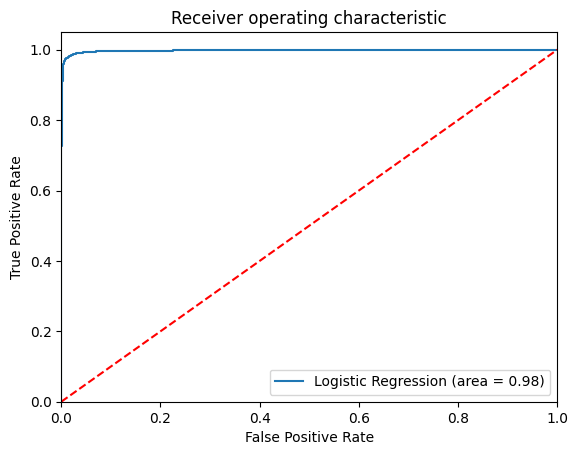

In [122]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

**Precision-Recall Curve**

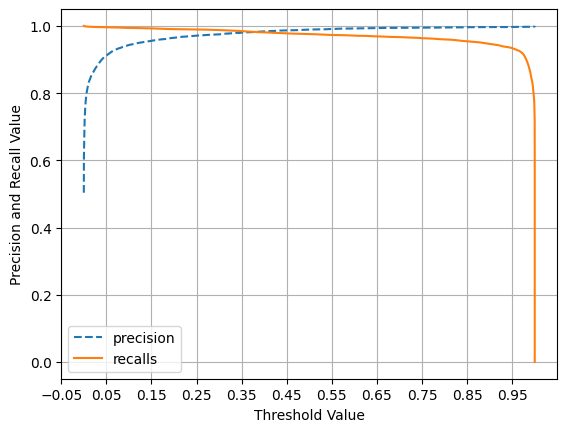

In [123]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    threshold_boundary = thresholds.shape[0]
    # plot precision
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    # plot recall
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recalls')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold Value'); plt.ylabel('Precision and Recall Value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, logreg.predict_proba(X_test)[:,1])

**K-fold Validation**

In [132]:
#X = scaler.fit_transform(X)

kfold = KFold(n_splits=5)
accuracy = np.mean(cross_val_score(logreg, scaled_df, y, cv=kfold, scoring='accuracy', n_jobs=-1)) 
print("Cross Validation accuracy: {:.3f}".format(accuracy))

Cross Validation accuracy: 1.000


**Conclusion:** Cross Validation accuracy is 100%

## Random Forest with class weights

In [114]:
from sklearn.utils import class_weight

In [115]:
param = {'max_depth':[2,3,4], 'n_estimators':[50,100,150,200]}

random_forest = RandomForestClassifier(class_weight ='balanced')

c = GridSearchCV(random_forest,param,cv=3,scoring='f1')
c.fit(X_train,y_train)

def display(results):
    print(f'Best parameters are : {results.best_params_}')
    print(f'The score is : {results.best_score_}')
display(c)
y_pred = c.predict(X_test)
   
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)

Best parameters are : {'max_depth': 4, 'n_estimators': 50}
The score is : 0.9877147053244321
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     11505
           1       0.99      0.99      0.99     11674

    accuracy                           0.99     23179
   macro avg       0.99      0.99      0.99     23179
weighted avg       0.99      0.99      0.99     23179

[[11360   145]
 [  122 11552]]


In [144]:
y_pred = c.predict(X_test)
print('Accuracy of Random Forest Classifier on test set: {:.3f}'.format(c.score(X_test, y_test)))

Accuracy of Random Forest Classifier on test set: 0.986


### Random Forest Classifier

In [146]:
param = {'max_depth':[2,3,4], 'n_estimators':[50,100,150,200]}

random_forest = RandomForestClassifier(class_weight ='balanced')

c = GridSearchCV(random_forest,param,cv=3,scoring='f1')
c.fit(X_train,y_train)

def display(results):
    print(f'Best parameters are : {results.best_params_}')
    print(f'The score is : {results.best_score_}')
display(c)

Best parameters are : {'max_depth': 4, 'n_estimators': 200}
The score is : 0.9871694700725587


In [148]:
pred = c.predict(X_test)
print(classification_report(y_test,pred))
#print(confusion_matrix(y_test,pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     11505
           1       0.98      0.99      0.99     11674

    accuracy                           0.99     23179
   macro avg       0.99      0.99      0.99     23179
weighted avg       0.99      0.99      0.99     23179



In [149]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[11504     1]
 [    5 11669]]


### XGBoost Classifier

In [150]:
import xgboost as xgb
my_model = xgb.XGBClassifier(class_weight ='balanced')
my_model.fit(X_train, y_train)
   
# Predicting the Test set results
y_pred = my_model.predict(X_test)
   
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11505
           1       1.00      1.00      1.00     11674

    accuracy                           1.00     23179
   macro avg       1.00      1.00      1.00     23179
weighted avg       1.00      1.00      1.00     23179



### Decision Tree classifer 

In [195]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11505
           1       1.00      1.00      1.00     11674

    accuracy                           1.00     23179
   macro avg       1.00      1.00      1.00     23179
weighted avg       1.00      1.00      1.00     23179



In [204]:
y_pred = y_pred.reshape(23179,1)

In [206]:
y_pred.shape, y_test.shape

((23179, 1), (23179,))

In [ ]:
### Feature Importance for the best model

In [226]:
param = {'max_depth':[2,3,4], 'n_estimators':[50,100,150,200]}

random_forest = RandomForestClassifier(class_weight ='balanced')

random_forest.fit(X_train,y_train)

def display(results):
    print(f'Best parameters are : {results.best_params_}')
    print(f'The score is : {results.best_score_}')
display(c)

Best parameters are : {'max_depth': 4, 'n_estimators': 200}
The score is : 0.9871694700725587


In [228]:
import time
import numpy as np

start_time = time.time()
importances = random_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.025 seconds


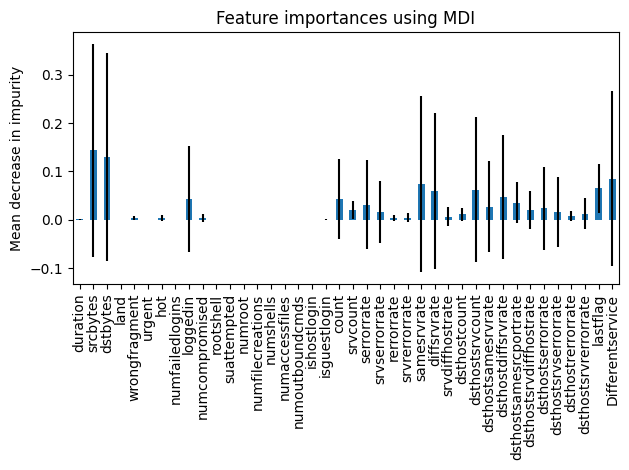

In [229]:
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

**Cross validation for Decision Tree classifier**

In [209]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(random_state=42)

In [210]:
#Target Variable
y = scaled_df['target_normal']
# split into 80:20 ration
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 7)

In [193]:
pd.isna(scaled_df['target_normal']).value_counts()

target_normal
False    115895
Name: count, dtype: int64

In [211]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((92716, 40), (23179, 40), (92716,), (23179,))

In [212]:
# Train on training data
tree_clf.fit(X_train,y_train)

# predict on test data
tree_clf.score(X_test,y_test)

0.9990077225074421

In [213]:
from sklearn.model_selection import KFold, cross_validate

kfold = KFold(n_splits=10)
cv_acc_results = cross_validate(tree_clf, X_train,y_train, cv = kfold, scoring = 'accuracy', return_train_score = True)

print(f"K-Fold Accuracy Mean: Train: {cv_acc_results['train_score'].mean()*100} Validation: {cv_acc_results['test_score'].mean()*100}")
print(f"K-Fold Accuracy Std: Train: {cv_acc_results['train_score'].std()*100} Validation: {cv_acc_results['test_score'].std()*100}")

K-Fold Accuracy Mean: Train: 100.0 Validation: 99.86410024151499
K-Fold Accuracy Std: Train: 0.0 Validation: 0.02862122616236794


**Confusion Matrix**

Text(0.5, 23.52222222222222, 'Predicted label')

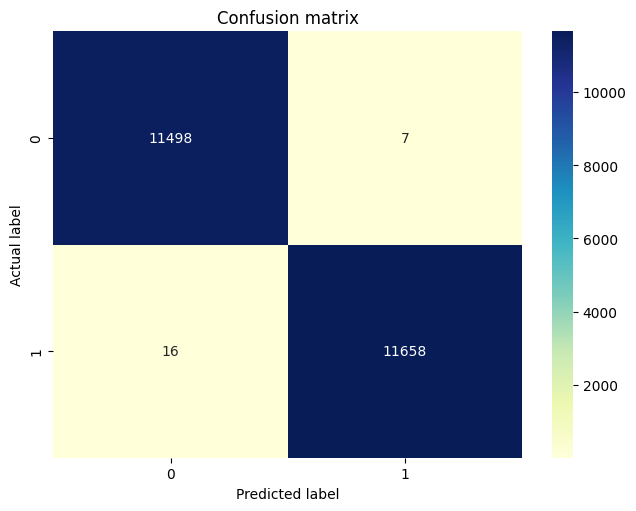

In [218]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cnf_matrix = confusion_matrix(y_test, tree_clf.predict(X_test))
# class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
# tick_marks = np.arange(len(class_names))
# plt.xticks(tick_marks, class_names)
# plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
# ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

**Feature Importance for Decision Tree Classifier**

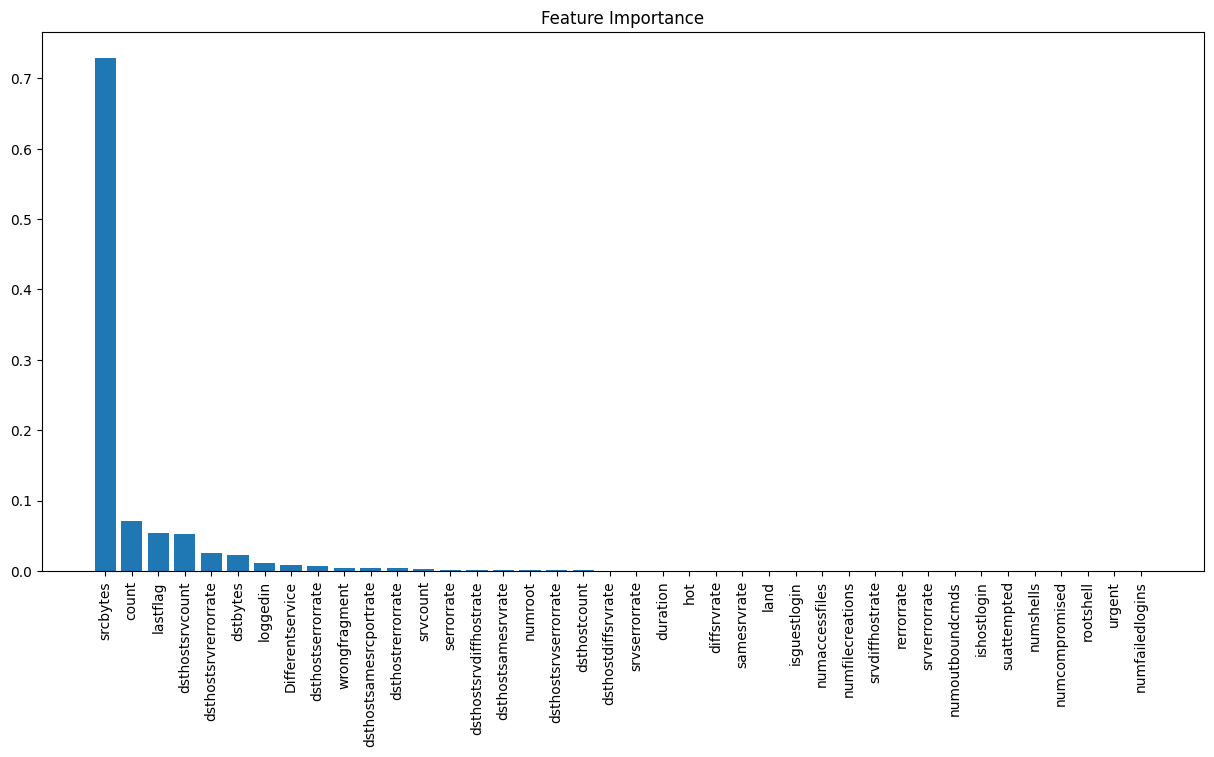

In [219]:
importances = tree_clf.feature_importances_
indices = np.argsort(importances)[::-1] # Sort feature importances in descending order
names = [X_train.columns[i] for i in indices] # Rearrange feature names so they match the sorted feature importances

plt.figure(figsize=(15, 7)) # Create plot
plt.title("Feature Importance") # Create plot title
plt.bar(range(X_train.shape[1]), importances[indices]) # Add bars
plt.xticks(range(X_train.shape[1]), names, rotation=90) # Add feature names as x-axis labels
plt.show() # Show plot

In [221]:
df_param_coeff = pd.DataFrame(columns=['Feature', 'Coefficient'])
for i in range(len(list(X_train.columns))):
    feat = X_train.columns[i]
    coeff = importances[i]
    df_param_coeff.loc[i] = (feat, coeff)
df_param_coeff.sort_values(by='Coefficient', ascending=False, inplace=True)
df_param_coeff = df_param_coeff.reset_index(drop=True)
df_param_coeff.head(10)

,Feature,Coefficient
0,srcbytes,0.729379
1,count,0.070630
2,lastflag,0.053297
3,dsthostsrvcount,0.051795
4,dsthostsrvrerrorrate,0.026078
5,dstbytes,0.022820
6,loggedin,0.010843
7,Differentservice,0.007788
8,dsthostserrorrate,0.006322
9,wrongfragment,0.003789


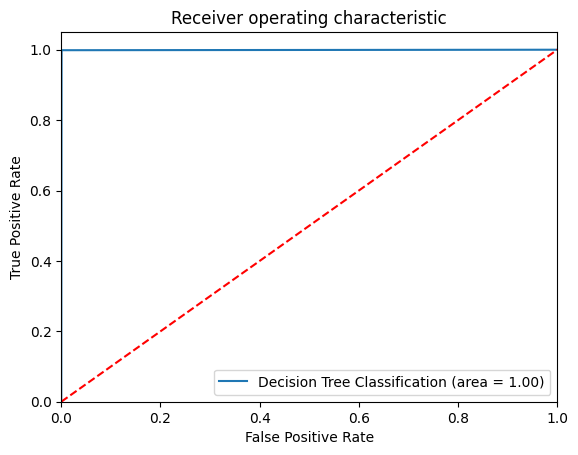

In [224]:
DT_roc_auc = roc_auc_score(y_test, tree_clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, tree_clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Decision Tree Classification (area = %0.2f)' % DT_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

**Precision-Recall Tree for Decision Tree Classifier**

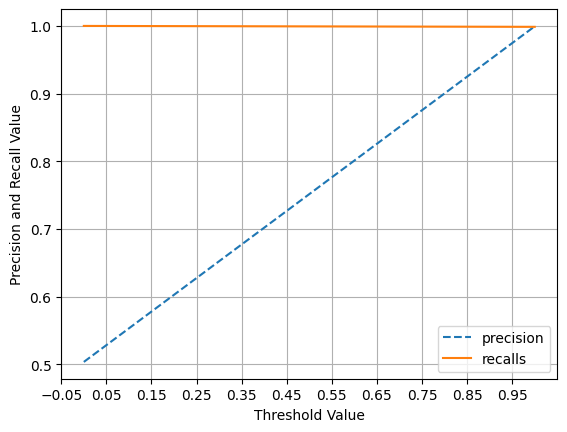

In [225]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    threshold_boundary = thresholds.shape[0]
    # plot precision
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    # plot recall
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recalls')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold Value'); plt.ylabel('Precision and Recall Value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, tree_clf.predict_proba(X_test)[:,1])

### Linear SVM 

In [231]:
from sklearn import svm

# an initial SVM model with linear kernel   
svm_linear = svm.SVC(kernel='linear')

# fit
svm_linear.fit(X_train, y_train)

SVC(kernel='linear')

In [233]:
predictions = svm_linear.predict(X_test)
predictions[:10]

array([0, 0, 1, 1, 0, 1, 0, 1, 1, 0])

In [234]:
confusion = metrics.confusion_matrix(y_true = y_test, y_pred = predictions)
confusion

array([[11398,   107],
       [  291, 11383]])

In [235]:
# measure accuracy
metrics.accuracy_score(y_true=y_test, y_pred=predictions)

0.9828292851287803

### Model Evaluation

In [ ]:
### **Model performance**
**Supervised Model**	          **Accuracy	Precision	Recall	F1 Score**
Logistic Regression	            	0.982		0.98		0.98	 0.98
Random Forest	    	            0.986		0.99		0.99	 0.99
Random Forest with class weights    0.988		0.99		0.99	 0.99
XGBoost Classifier		            1.00		1.00		1.00	 1.00
Support Vector Machine		        0.982		0.99		0.98	 0.98

**Conclusion:**
- The model evaluation results indicate exceptional performance across multiple classification algorithms, including Decision Tree, Logistic Regression, and XGBoost, with each model achieving an accuracy above 99%. This high level of accuracy suggests that the models are effectively capturing patterns in the dataset, providing reliable predictions for our classification task. Additionally, the K-fold cross-validation score of 98.86% on the training dataset demonstrates consistency and robustness, indicating that the models generalize well across different data splits and are unlikely to suffer from overfitting.
- Among these models, XGBoost often tends to excel in handling complex data structures due to its boosting approach, which iteratively improves model performance. However, achieving comparable results with both Decision Tree and Logistic Regression reinforces the reliability of the feature set and preprocessing steps used.
- To summarize, the high accuracy and validation scores validate the choice of models and confirm that our pipeline is well-suited for achieving precise anomaly detection, with the potential for reliable application in real-world scenarios.
- Recall is a crucial metric for anomaly detection because it measures the model's ability to correctly identify actual anomalies among all true anomalies.
- In anomaly detection, the primary goal is to identify as many real anomalies as possible, as they often indicate critical issues like security breaches, fraud, or system failures. High recall ensures that the model successfully captures the majority of actual anomalies, minimizing the number of false negatives.

**Final Conclusion on Model Evaluation**
- In exploring network anomaly detection, we delved into both supervised and unsupervised machine learning algorithms, each offering unique strengths in identifying and managing anomalies. Supervised classification algorithms such as Decision Trees, Logistic Regression, and XGBoost have demonstrated high accuracy in detecting known anomalies by learning from labelled data. These models excel in identifying patterns linked to historical attacks or unusual behaviours, making them effective for real-time, automated monitoring once trained. Achieving over 99% accuracy across these algorithms emphasizes the reliability and robustness of our feature engineering and model selection.
- On the other hand, unsupervised algorithms like K-Means Clustering and Local Outlier Factor (LOF) allow for more flexible anomaly detection, particularly with novel or evolving attack patterns where labelled data is unavailable. These methods identify atypical network behaviours by spotting data points that diverge from expected norms, providing an essential layer of defence against unknown or rare threats.
- By combining these supervised and unsupervised approaches, we create a more comprehensive and adaptive anomaly detection system. Supervised methods ensure high precision for known threats, while unsupervised techniques offer resilience against new, unforeseen risks. This hybrid approach, tailored to network security’s dynamic environment, provides a strong foundation for continuous monitoring and proactive threat mitigation, ensuring that networks remain secure, operational, and resilient in the face of an evolving cybersecurity landscape.
